In [34]:
import matplotlib.pyplot as plt
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.optim.phase_retrieval import correct_global_phase

In [35]:
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("CBSD_0010.png")
x = load_url_image(url, grayscale=False).to(device)

x = torch.tensor(x, device=device, dtype=torch.float)
x = torch.nn.functional.interpolate(x, size=(8, 8))

# supress saturated pixels to avoid reconstruction issues using torch.angle()
x = torch.where(x > 0.99999, 0.99999, x)
x = torch.where(x < 0.00001, 0.00001, x)

img_shape = x.shape[1:]
print(f"Image shape: {img_shape}")

Image shape: torch.Size([3, 8, 8])


/var/folders/g7/kcfjzxyn1klcs6f0xk8vby0w0000gn/T/ipykernel_52679/3315323887.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=device, dtype=torch.float)


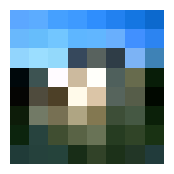

In [36]:
# visualization
# for complex numbers, plot() automatically plots the magnitude
plot(x)

In [37]:
# We use the original image as the phase information for the complex signal.
# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*2*torch.pi - 1j*torch.pi)

# For phase retrieval, the signal should be complex-valued.
print(x_phase.dtype)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

torch.complex64


In [38]:
# creates a random phase retrieval operator
# oversampling ratio
m = 3 * torch.prod(torch.tensor(img_shape))
print(f"Number of measurements: {m}")

physics = dinv.physics.RandomPhaseRetrieval(
    m = m,
    img_shape = img_shape,
)

y = physics(x_phase)

Number of measurements: 576


In [39]:
x.shape

torch.Size([1, 3, 8, 8])

loss_init: tensor([32.1972])
loss_final: tensor([2.2792])


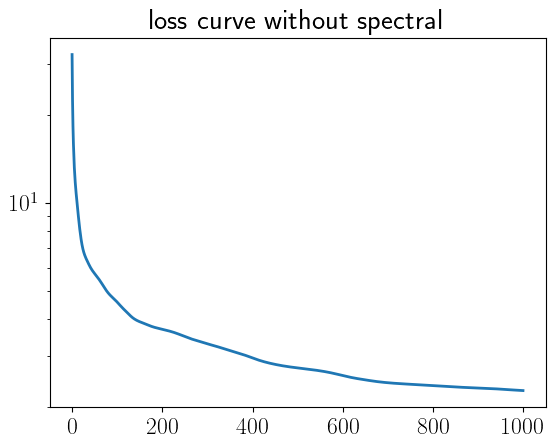

In [40]:
# run a gradient descent algorithm to recover the original image

loss_fn = dinv.optim.AmplitudeLoss()
iterator = dinv.optim.optim_iterators.GDIteration()
OPTIM_PARAMS = {"stepsize": 0.5, "lambda": 1.0, "g_param": []}
NUM_ITER = 1000

# initial guess
x_est = torch.rand_like(x_phase)

loss_hist = []

for _ in range(NUM_ITER):
    res = iterator({"est": (x_est,), "cost": 0},
        cur_data_fidelity=loss_fn,
        cur_prior=dinv.optim.Zero(),
        cur_params=OPTIM_PARAMS,
        y=y,
        physics=physics)
    x_est = res["est"][0]
    loss_hist.append(loss_fn(x_est, y, physics))

print("loss_init:",loss_hist[0])
print("loss_final:",loss_hist[-1])
plt.plot(loss_hist)
plt.yscale('log')
plt.title('loss curve without spectral')
plt.show()

Image 0, channel 0 does not have a global phase shift.
Image 0, channel 1 does not have a global phase shift.
Image 0, channel 2 does not have a global phase shift.


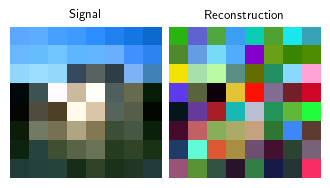

In [41]:
# correct possible global phase shifts
x_est = correct_global_phase(x_est, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_recon = torch.angle(x_est) / (2*torch.pi) + 0.5
#assert torch.allclose(x_recon, x, rtol=1e-3)
plot([x, x_recon],titles=["Signal","Reconstruction"])

loss_init: tensor([16.1479])
loss_final: tensor([1.5173e-12])


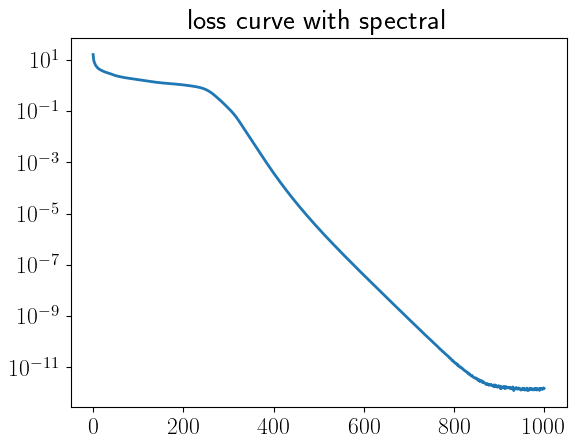

In [42]:
# spectral methods
x_est = torch.rand_like(x_phase)
x_est = x_est / torch.norm(x_est.flatten())

spectral = dinv.optim.optim_iterators.SMIteration()

diff_hist = []

# spectral methods iteration
for _ in range(50):
    x_next = spectral(x_est,
                    dinv.optim.Zero(),
                    OPTIM_PARAMS,
                    y,
                    physics)
    diff_hist.append(torch.norm(x_next - x_est))
    x_est = x_next

x_est = x_est * torch.sqrt(y.sum())
x_est = x_est.reshape(x_phase.shape)

loss_hist = []
for _ in range(NUM_ITER):
    res = iterator({"est": (x_est,), "cost": 0},
        cur_data_fidelity=loss_fn,
        cur_prior=dinv.optim.Zero(),
        cur_params=OPTIM_PARAMS,
        y=y,
        physics=physics)
    x_est = res["est"][0]
    loss_hist.append(loss_fn(x_est, y, physics))

print("loss_init:",loss_hist[0])
print("loss_final:",loss_hist[-1])
plt.plot(loss_hist)
plt.yscale('log')
plt.title('loss curve with spectral')
plt.show()

Image 0, channel 0 has a constant global phase shift.
Image 0, channel 1 has a constant global phase shift.
Image 0, channel 2 has a constant global phase shift.


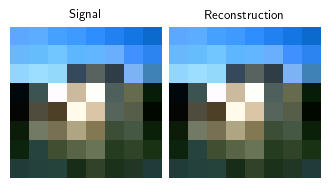

In [43]:
# correct possible global phase shifts
x_est = correct_global_phase(x_est, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_recon = torch.angle(x_est) / (2*torch.pi) + 0.5
#assert torch.allclose(x_recon, x, rtol=1e-3)
plot([x, x_recon],titles=["Signal","Reconstruction"])

In [44]:
x - x_recon

tensor([[[[-2.9802e-08, -2.9802e-08,  2.9802e-08,  0.0000e+00, -2.9802e-08,
            1.4901e-08, -1.4901e-08,  1.4901e-08],
          [ 2.9802e-08,  0.0000e+00,  5.9605e-08, -2.9802e-08,  0.0000e+00,
            2.9802e-08,  2.9802e-08,  2.9802e-08],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.9802e-08,  0.0000e+00,
            2.9802e-08,  0.0000e+00,  2.9802e-08],
          [ 3.7253e-08,  2.9802e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           -2.9802e-08,  0.0000e+00,  1.4901e-08],
          [ 7.4506e-09, -2.9802e-08, -2.9802e-08,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  2.9802e-08,  3.7253e-08],
          [-1.4901e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           -2.9802e-08,  0.0000e+00,  4.4703e-08],
          [ 7.4506e-08,  1.4901e-08,  2.9802e-08,  0.0000e+00, -2.9802e-08,
           -1.4901e-08,  0.0000e+00, -1.4901e-08],
          [-1.4901e-08, -7.4506e-08,  4.4703e-08, -4.4703e-08, -2.9802e-08,
            1.4901e-08,  1.4901e-08